# Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

DATA DICTIONARY

1. Sl_No: Primary key of the records
2. Customer Key: Customer identification number
3. Average Credit Limit: Average credit limit of each customer for all credit cards
4. Total credit cards: Total number of credit cards possessed by the customer
5. Total visits bank: Total number of visits that customer made (yearly) personally to the bank
6. Total visits online: Total number of visits or online logins made by the customer (yearly) 
7. Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)



In [1]:
#pip install -U yellowbrick

In [2]:
#pip install threadpoolctl==3.1.0

In [3]:
# Library to suppress warnings or deprecation notes 
import warnings
warnings.filterwarnings('ignore')

import os

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Libraries to split data, impute missing values 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Import to support Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline 

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to compute distances
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

In [4]:
## Let's load the specific tab in the xls sheet
url = 'https://github.com/fdletter1980/fdletter1980.github.io/blob/1e538c356cdc40559fff0a4b0e9c9f3f262eba17/Unsupervised%20ML/Credit%20Card%20Customer%20Data.xlsx?raw=true'
data = pd.read_excel(url, 'Sheet1')

In [5]:
## copying data to another varaible to avoid any changes to original data
df = data.copy()

In [6]:
df

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
...,...,...,...,...,...,...,...
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0


In [7]:
## We'll check the shape of the data

df.shape

(660, 7)

In [8]:
## Checking for duplicaes in the data

df.duplicated().sum()

0

In [9]:
## Retrieve info around the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [10]:
## Summary of the dataset

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


# Data Preprocessing

In [11]:
# We are deleting CLIENTNUM column

df.drop(['Sl_No'], axis = 1, inplace = True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Customer Key         660 non-null    int64
 1   Avg_Credit_Limit     660 non-null    int64
 2   Total_Credit_Cards   660 non-null    int64
 3   Total_visits_bank    660 non-null    int64
 4   Total_visits_online  660 non-null    int64
 5   Total_calls_made     660 non-null    int64
dtypes: int64(6)
memory usage: 31.1 KB


# EDA

# Univariate Analysis (& Some Initial Bivariate Analysis)

In [13]:
## Creating a copy of the data as is excluding Customer Key for EDA and clustering going forward. 
## We want to keep the Customer_Key in the original data so we can indentify later on in which cluster which customer resides.

cluster_cols = [
    "Avg_Credit_Limit",
    "Total_Credit_Cards",
    "Total_visits_bank",
    "Total_visits_online",
    "Total_calls_made"
]

In [14]:
df1 = df[cluster_cols].copy()
df1.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


In [15]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [16]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

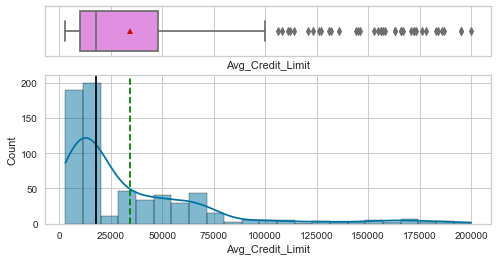

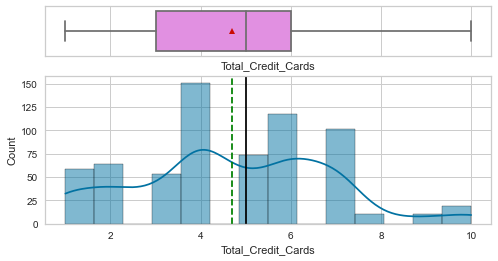

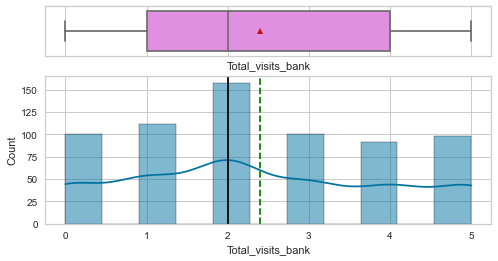

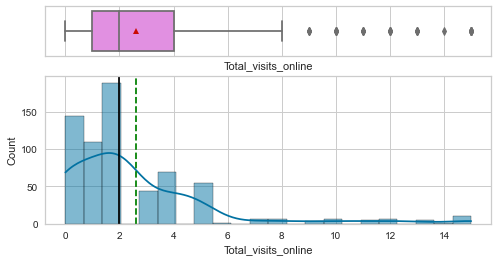

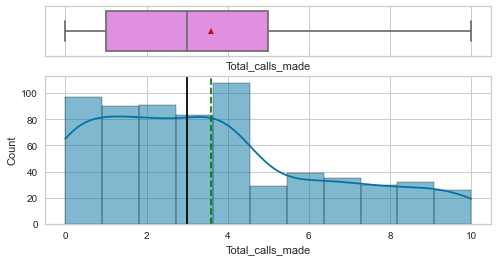

In [17]:
for item in cluster_cols:
    histogram_boxplot(df1, item, kde=True, figsize=(8, 4))

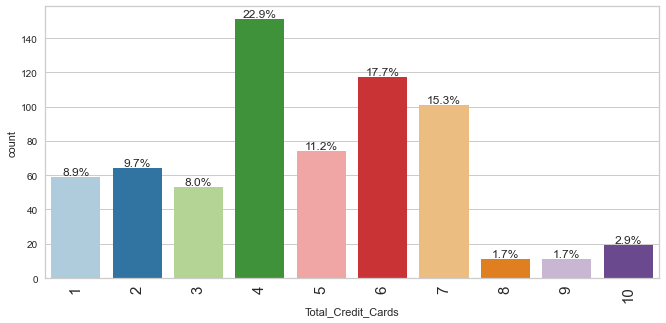

In [18]:
labeled_barplot(df1, "Total_Credit_Cards",perc=True)

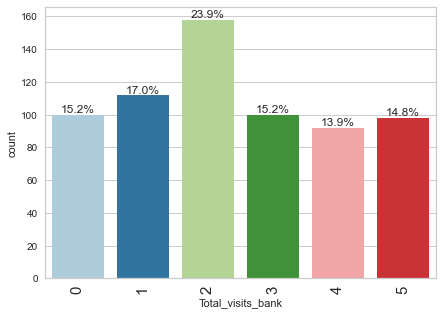

In [19]:
labeled_barplot(df1, "Total_visits_bank",perc=True)

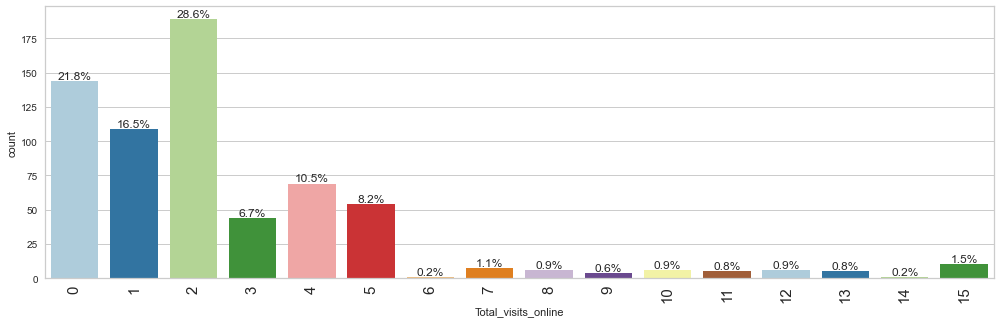

In [20]:
labeled_barplot(df1, "Total_visits_online",perc=True)

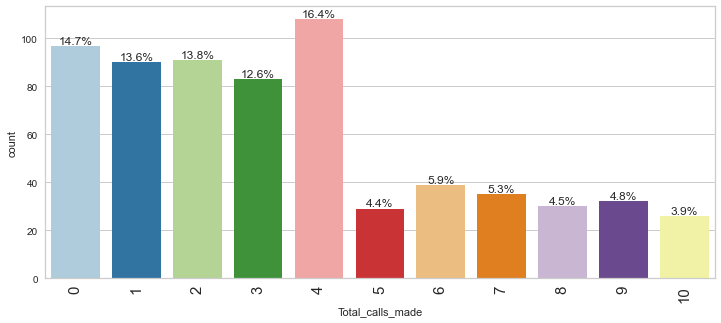

In [21]:
labeled_barplot(df1, "Total_calls_made",perc=True)

# Some Additional Bivariate Analysis

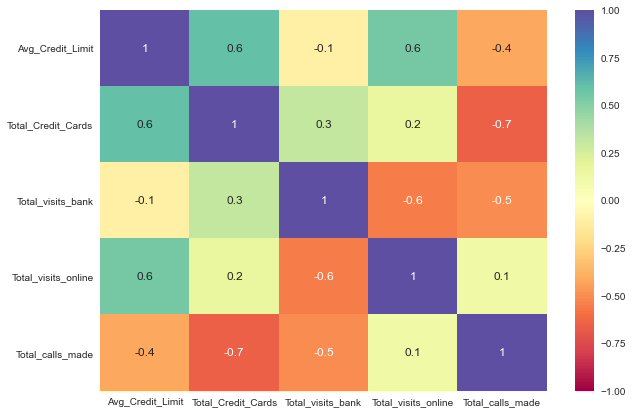

In [22]:
plt.figure(figsize=(10,7))
sns.heatmap(df1.corr(),annot=True,vmin=-1,vmax=1,fmt='.1g',cmap="Spectral")
plt.show()

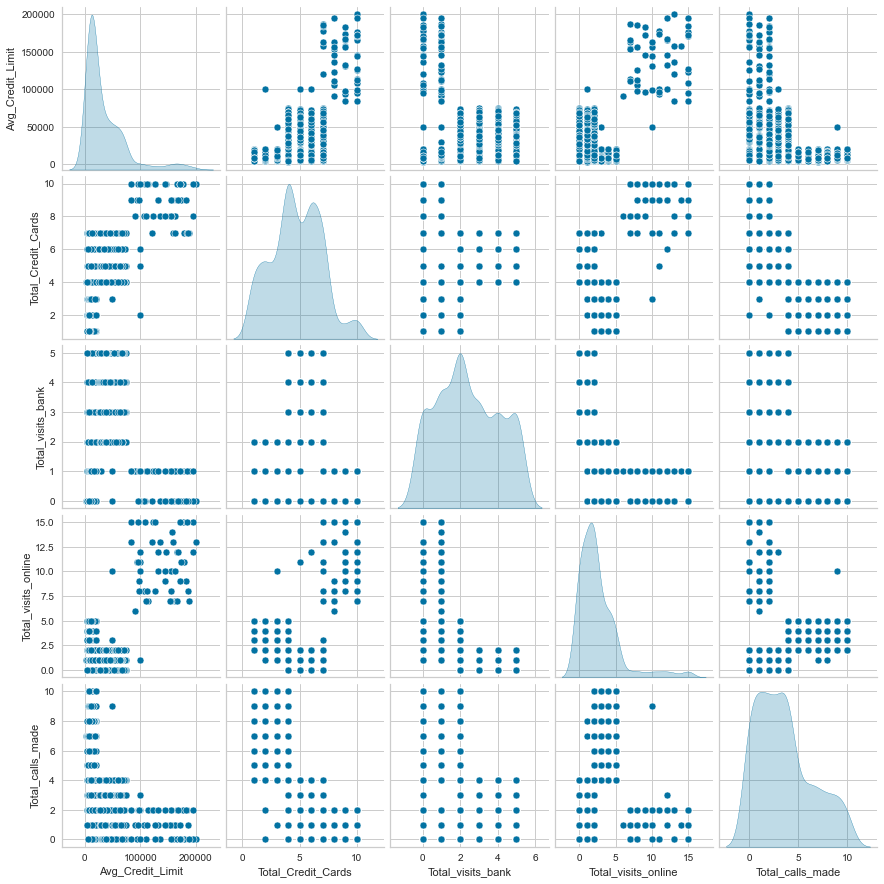

In [23]:
sns.pairplot(data=df1, diag_kind="kde")
plt.show()

# Model Building

In [24]:
# Scaling the data set before clustering
scaler = StandardScaler()
subset = df1.copy()
subset_scaled = scaler.fit_transform(subset)

In [25]:
# Creating a dataframe from the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

In [26]:
subset_scaled_df

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739
...,...,...,...,...,...
655,1.713589,2.443892,-0.860451,2.520519,-1.251537
656,1.314621,2.443892,-0.860451,3.543188,-0.553005
657,2.937092,1.520613,-0.860451,2.179629,-0.902271
658,3.655235,2.443892,-0.860451,4.224968,-1.251537


# Applying K-means Clustering

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9908683849620168
Number of Clusters: 6 	Average Distortion: 0.9429789712808515
Number of Clusters: 7 	Average Distortion: 0.9094949294930519
Number of Clusters: 8 	Average Distortion: 0.8923824817011573


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

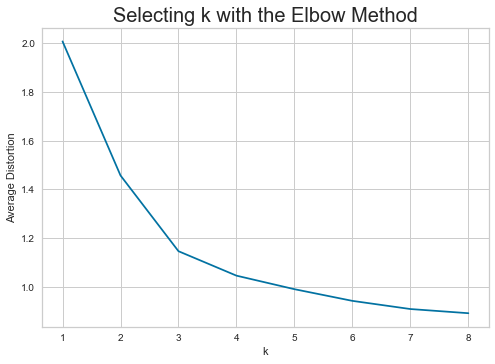

In [27]:
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

For n_clusters = 2, silhouette score is 0.41842496663230405
For n_clusters = 3, silhouette score is 0.5157182558882754
For n_clusters = 4, silhouette score is 0.355667061937737
For n_clusters = 5, silhouette score is 0.2723916744639754
For n_clusters = 6, silhouette score is 0.2558365757121271
For n_clusters = 7, silhouette score is 0.24857354615474053
For n_clusters = 8, silhouette score is 0.22673516198083338
For n_clusters = 9, silhouette score is 0.21218548760130468


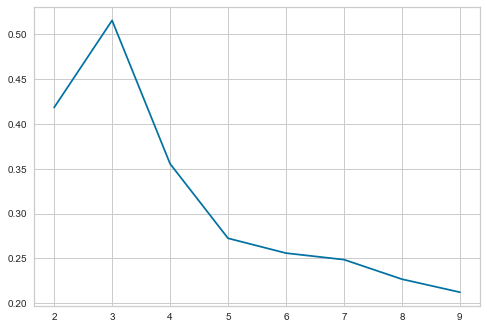

In [28]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

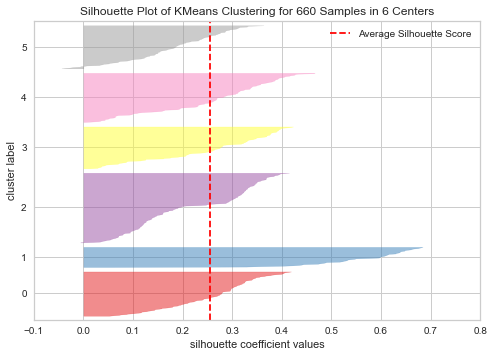

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [29]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

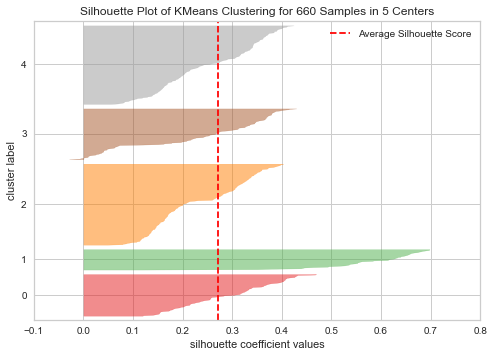

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [30]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

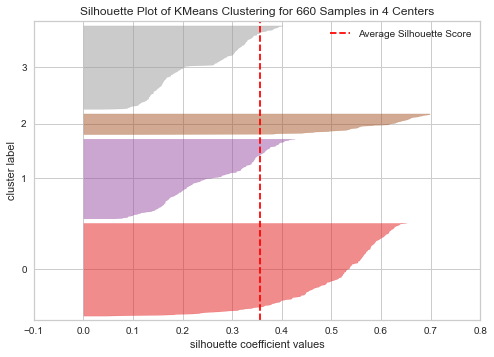

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [31]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

In [32]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=5, random_state=0)

In [33]:
# adding kmeans cluster labels to the original dataframe
df["K_means_segments"] = kmeans.labels_

In [34]:
cluster_profile = df.groupby("K_means_segments").mean()

In [35]:
cluster_profile["count_in_each_segment"] = (
    df.groupby("K_means_segments")["Customer Key"].count().values
)

In [36]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,,
0,54766.317073,12300.813008,2.357724,0.878049,3.626016,8.398374,123
1,55714.684211,31226.315789,5.478947,4.515789,1.010526,1.936842,190
2,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,50
3,55816.485149,12019.801980,2.475248,1.000000,3.465347,5.009901,101
4,54073.484694,36260.204082,5.551020,2.494898,0.954082,2.061224,196


In [37]:
df1

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3
...,...,...,...,...,...
655,99000,10,1,10,0
656,84000,10,1,13,2
657,145000,8,1,9,1
658,172000,10,1,15,0


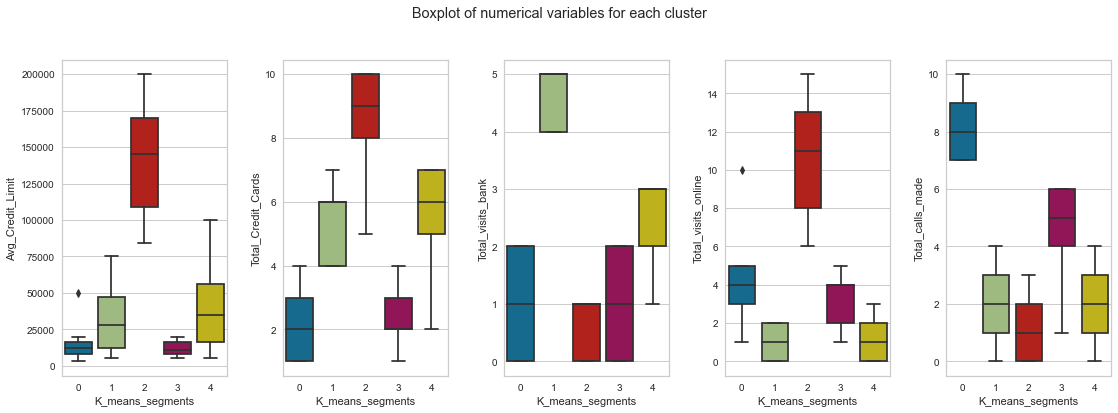

In [38]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[cluster_cols[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

<AxesSubplot:xlabel='K_means_segments'>

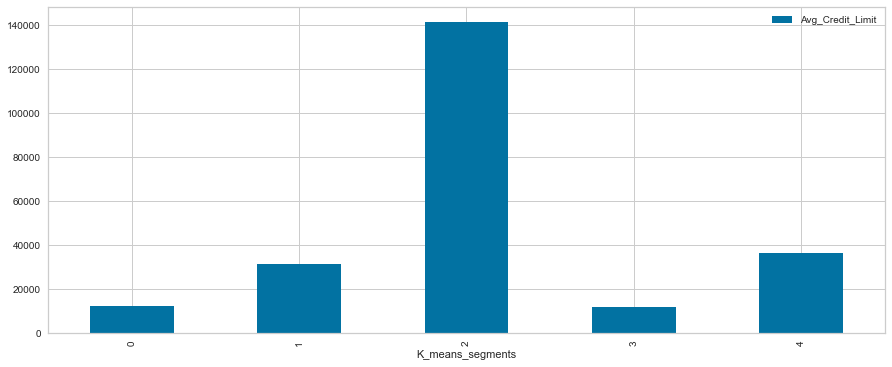

In [39]:
## Due to the number range differences we're going to show Avg_Credit_Limit seperately 

df[["Avg_Credit_Limit", "K_means_segments"]].groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

<AxesSubplot:xlabel='K_means_segments'>

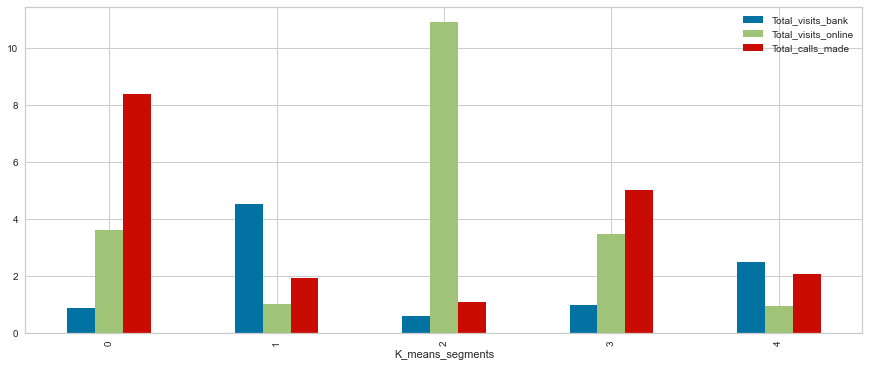

In [40]:
df[["Total_visits_bank", "Total_visits_online", "Total_calls_made", "K_means_segments"]].groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

# Insights about the clusters

Segment 0: Customers in this segment appear to have the following key characteristics:
    1. Low account credit limit.
    2. Lower number of credit cards.
    3. Visits to the bank and online are average compared to other segments.
    4. Much higher calls made compared to other segments.

Segment 1: Customers in this segment appear to have the following key characteristics:
    1. Average account credit limit.
    2. Average number of credit cards.
    3. Very high visits to bank but very low visits online. So more face to face preference.
    4. Average number of calls made.

Segment 2: Customers in this segment appear to have the following key characteristics:
    1. Very high account credit limit
    2. Very high number of credit cards.
    3. Lower number of visits to the bank but very high on online visits. Prefer digital communication and interaction. 
    4. Low number of calls made.

Segment 3: Customers in this segment appear to have the following key characteristics:
    1. Low account credit limit.
    2. Lower number of credit cards.
    3. Visits to the bank and online are average compared to other segments.
    4. Higher number of calls made.

Segment 4: Customers in this segment appear to have the following key characteristics:
    1. Average account credit limit.
    2. Higher number of credit cards
    3. Higher number of visits to bank but low visits online
    4. Average number of calls made.


# Hierarchical Clustering

In [41]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553605.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.666353446387536.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042136.
Cophenetic cor

In [42]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


In [43]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


In [44]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


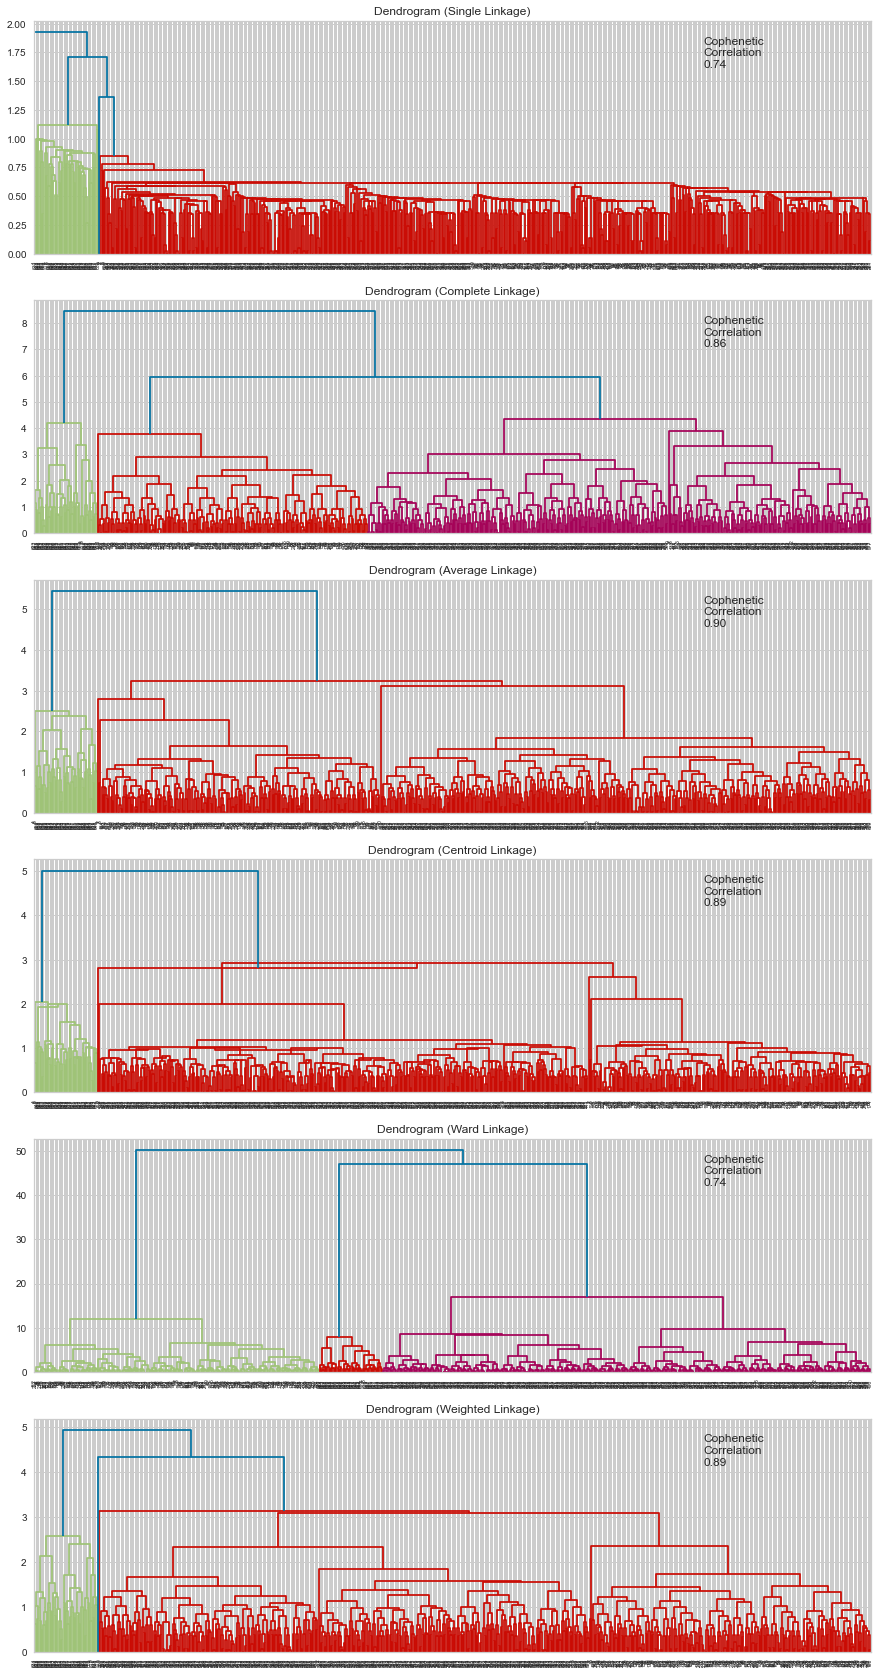

In [45]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

In [46]:
HCmodel = AgglomerativeClustering(n_clusters=6, affinity="euclidean", linkage="average")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=6)

In [47]:
subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

# Cluster Profiling

In [48]:
cluster_profile = df.groupby("HC_Clusters").mean()

In [49]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("HC_Clusters")["Customer Key"].count().values
)

In [50]:
# let's see the names of the countries in each cluster
for cl in df["HC_Clusters"].unique():
    print(
        "The",
        df[df["HC_Clusters"] == cl]["Customer Key"].nunique(),
        "Customers in cluster",
        cl,
        "are:",
    )
    print(df[df["HC_Clusters"] == cl]["Customer Key"].unique())
    print("-" * 100, "\n")

The 1 Customers in cluster 3 are:
[87073]
---------------------------------------------------------------------------------------------------- 

The 1 Customers in cluster 4 are:
[38414]
---------------------------------------------------------------------------------------------------- 

The 384 Customers in cluster 2 are:
[17341 40496 54838 35254 46635 97825 83125 35483 15129 83290 56486 31903
 45909 14263 46813 81878 35549 85799 39122 81531 69965 18595 44398 32352
 40898 27101 33457 45088 23302 27408 65372 21531 56843 17165 89328 20072
 71402 47496 24808 17036 67193 34423 97109 55382 51811 53936 66504 53207
 18514 51319 36340 36934 95925 49771 22919 21233 74544 52025 45652 73952
 49418 77026 49331 75775 54906 94666 11698 34677 95610 41380 38033 85337
 38994 67911 92956 77641 57565 53814 30712 19785 31384 16374 50878 78002
 83459 91987 51552 72156 24998 45673 11596 87485 28414 81863 33240 11466
 23881 44645 49844 92782 22824 26767 26678 50412 17933 34495 47437 22610
 41159 64672 6248

In [51]:
# lets display cluster profile
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,count_in_each_segments
HC_Clusters,,,,,,,,
0,57075.645833,142750.000000,8.875000,0.625000,10.875000,1.020833,2.000000,48
1,55239.423423,12027.027027,2.400901,0.932432,3.531532,6.873874,1.351351,222
2,54842.683938,33541.450777,5.520725,3.492228,0.984456,2.010363,2.520725,386
3,87073.000000,100000.000000,2.000000,1.000000,1.000000,0.000000,4.000000,1
4,38414.000000,50000.000000,3.000000,0.000000,10.000000,9.000000,0.000000,1
5,47903.500000,100000.000000,5.500000,0.000000,11.500000,2.500000,2.000000,2


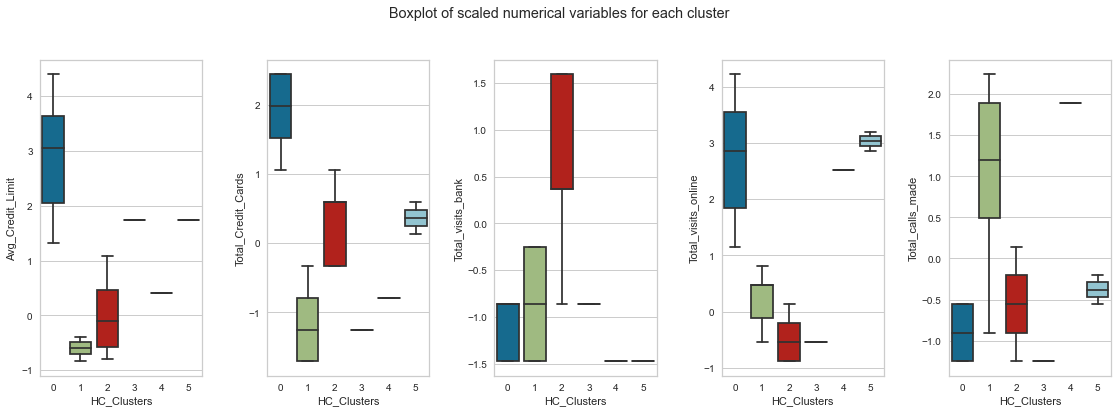

In [52]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=subset_scaled_df[cluster_cols[counter]], x=subset_scaled_df["HC_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

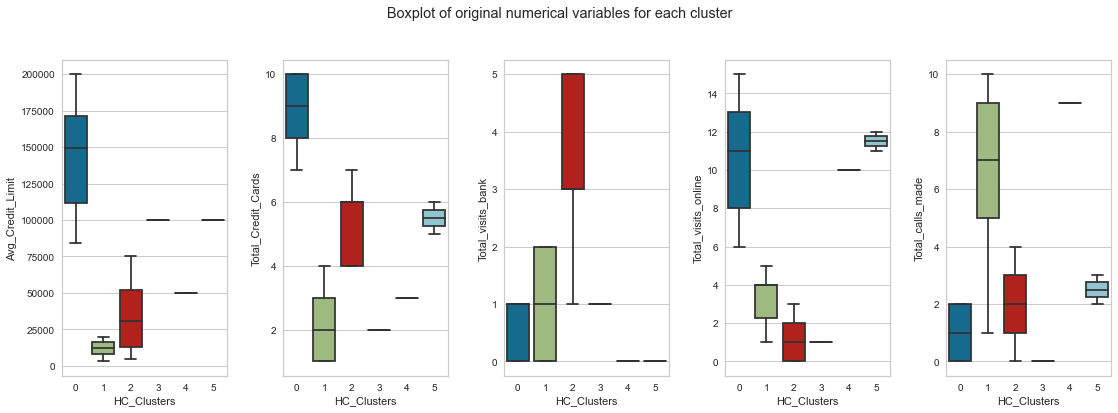

In [53]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[cluster_cols[counter]], x=df["HC_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

# PCA for Dimensionality Reduction

In [54]:
subset_scaled_df2 = subset_scaled_df.drop("HC_Clusters", axis=1).copy()

In [55]:
pca = PCA()
pca.fit(subset_scaled_df2)

PCA()

In [56]:
pca.explained_variance_ratio_

array([0.45736578, 0.37426483, 0.06401348, 0.0555688 , 0.04878711])

Text(0, 0.5, 'Cumulative Explained Variance')

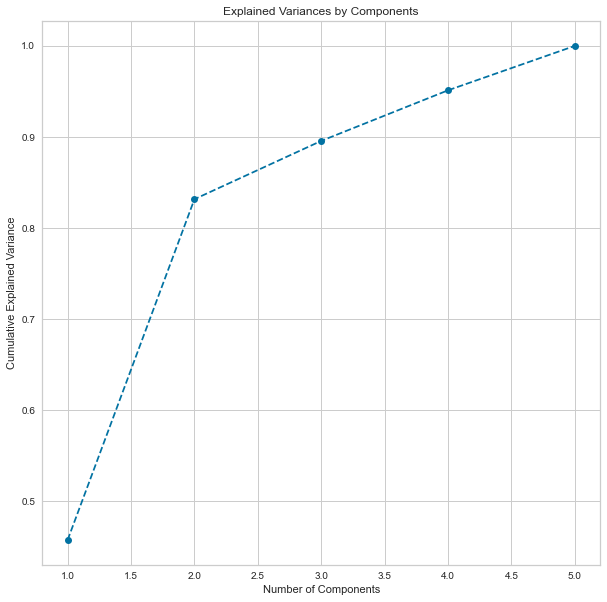

In [57]:
# visualizing the variance explained by individual principal components
plt.figure(figsize=(10, 10))
plt.plot(
    range(1, 6), pca.explained_variance_ratio_.cumsum(), marker="o", linestyle="--"
)
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

In [58]:
pca = PCA(
    0.9, svd_solver="full"
)  # svd_solver=full helps in faster convergence in case of very large data set
pca.fit(subset_scaled_df2)

PCA(n_components=0.9, svd_solver='full')

In [59]:
# checking the variance explained by individual components.
pca.explained_variance_ratio_

array([0.45736578, 0.37426483, 0.06401348, 0.0555688 ])

Text(0, 0.5, 'Cumulative Explained Variance')

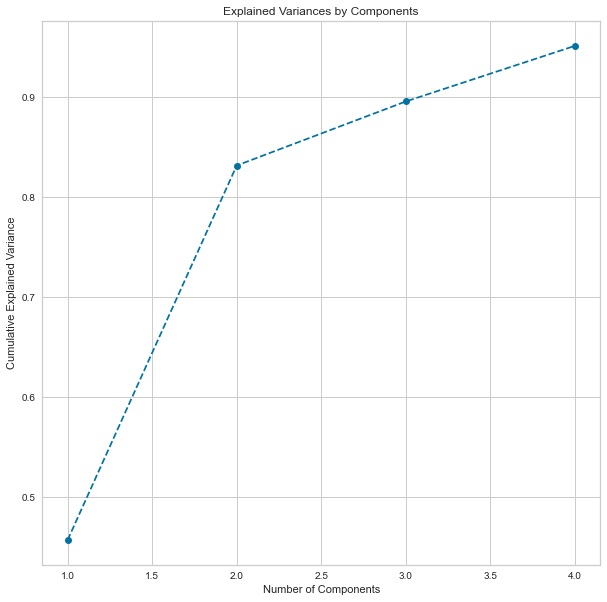

In [60]:
plt.figure(figsize=(10, 10))
plt.plot(
    range(1, 5), pca.explained_variance_ratio_.cumsum(), marker="o", linestyle="--"
)
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

In [61]:
subset_pca = pca.transform(subset_scaled_df2)
subset_pca_df = pd.DataFrame(subset_pca)

# Hierarchical Clustering on lower-dimensional data

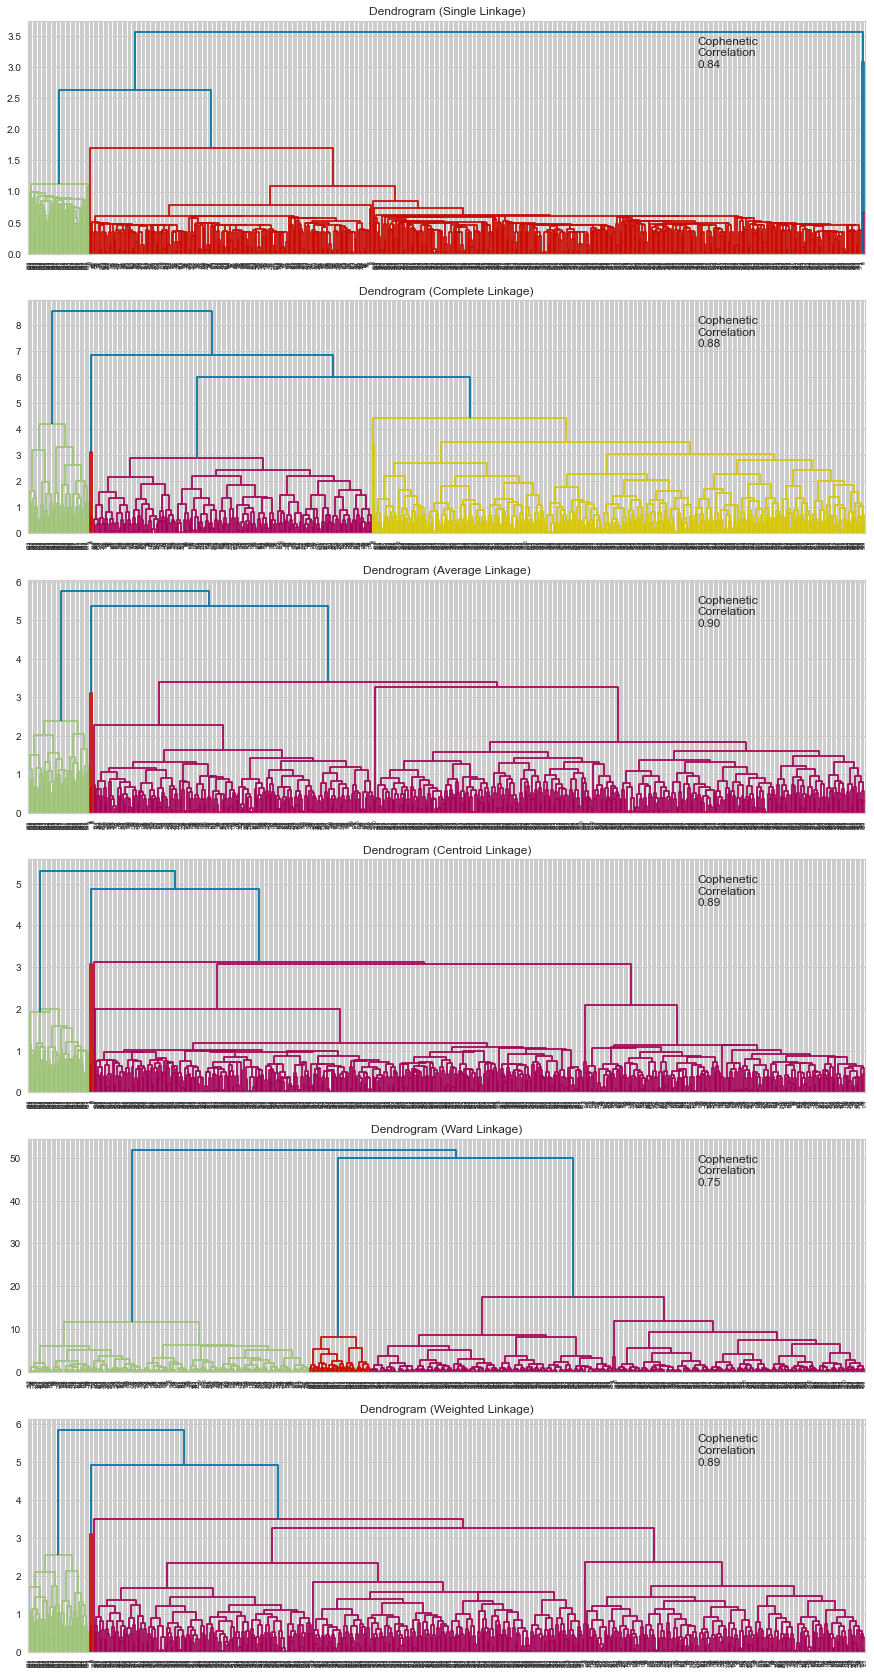

In [62]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_pca_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

In [63]:
hc = AgglomerativeClustering(n_clusters=6, affinity="euclidean", linkage="ward")
hc_labels = hc.fit_predict(subset_pca)

In [64]:
# adding hierarchical cluster labels to the original dataframe
df2 = df.drop(["HC_Clusters"], axis=1)
df2["PCA_HC_Clusters"] = hc_labels

# Cluster Profiling

In [65]:
cluster_profile2 = df2.groupby("PCA_HC_Clusters").mean()
cluster_profile2["count_in_each_segments"] = (
    df2.groupby("PCA_HC_Clusters")["Customer Key"].count().values
)

In [66]:
# let's see the names of the customers in each cluster
for cl in df2["PCA_HC_Clusters"].unique():
    print(
        "The",
        df2[df2["PCA_HC_Clusters"] == cl]["Customer Key"].nunique(),
        "customers in cluster",
        cl,
        "are:",
    )
    print(df2[df2["PCA_HC_Clusters"] == cl]["Customer Key"].unique())
    print("-" * 100, "\n")

The 86 customers in cluster 5 are:
[87073 45909 14263 46813 35549 81531 23302 20072 47496 52025 49331 11698
 34677 57565 72156 45673 44645 70779 67046 64897 81940 87838 47866 61996
 71862 88807 82376 80347 17649 61994 45878 19215 85122 31113 68439 88207
 29864 45440 45808 53932 25321 48602 48657 41287 52460 58019 14439 81166
 14816 84351 64774 36504 29919 51682 95147 23102 44144 62530 41741 64550
 43000 48692 43034 91242 58708 57451 69868 30256 26334 47848 34775 75398
 97850 75366 31870 24748 67637 59170 93310 36836 67860 93381 44403 85234
 31948 11562]
---------------------------------------------------------------------------------------------------- 

The 81 customers in cluster 4 are:
[38414 92503 55196 24001 68067 65034 14854 82164 28254 46388 52142 37659
 83132 99026 51182 96386 43886 78503 17937 81566 36929 61355 66524 33187
 59656 99589 38165 49198 59619 91099 25742 88338 96213 26599 97935 26089
 41634 83244 87291 93997 25440 63663 39454 70199 14248 95507 23743 53410
 59151 604

In [67]:
# let's display cluster profile
cluster_profile2.style.highlight_max(color="lightgreen", axis=0)

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,count_in_each_segments
PCA_HC_Clusters,,,,,,,,
0,55348.862857,31982.857143,5.405714,4.560000,0.982857,1.805714,1.000000,175
1,52962.230769,12195.804196,2.496503,0.902098,3.321678,5.671329,2.125874,143
2,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50
3,55444.936000,33560.000000,6.408000,2.720000,0.928000,2.288000,3.640000,125
4,58869.913580,12419.753086,2.271605,0.975309,3.950617,8.987654,0.000000,81
5,53478.895349,37500.000000,4.430233,2.441860,1.069767,1.976744,3.988372,86


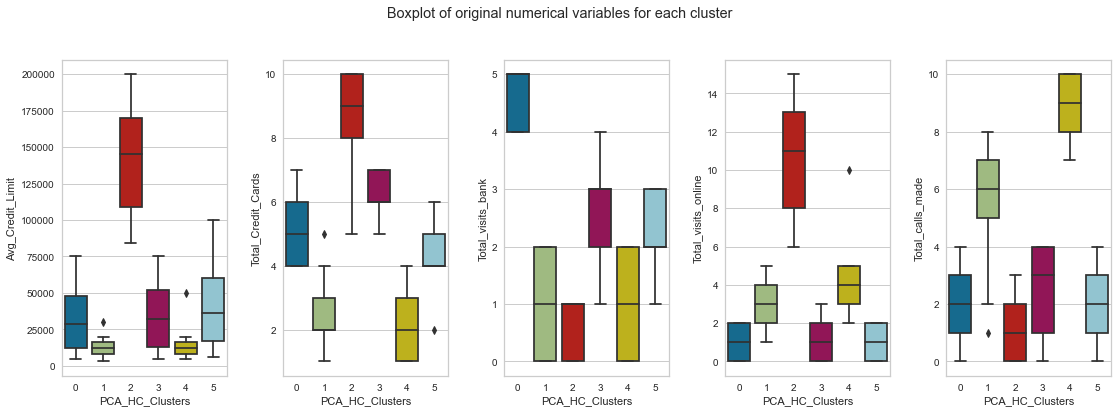

In [68]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df2[cluster_cols[counter]], x=df2["PCA_HC_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

# Model Save

In [69]:
import pickle

In [70]:
pkl_filename = "KMeans.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(kmeans, file)

In [ ]:
# Load from file if needed
#with open(pkl_filename, 'rb') as file:
#    pickle_model = pickle.load(file)

# Insights about the clusters

Segment 0: Customers in this segment appear to have the following key characteristics:
    1. Average account credit limit.
    2. Average number of credit cards.
    3. Very high visits to the bank but very low online. Prefer f2f communication.
    4. Lower calls made compared to other segments.

Segment 1: Customers in this segment appear to have the following key characteristics:
    1. Low account credit limit.
    2. Low number of credit cards.
    3. Low to Average visits to bank but low visits online.
    4. Higher number of calls made. Prefer calling.

Segment 2: Customers in this segment appear to have the following key characteristics:
    1. Very high account credit limit
    2. Very high number of credit cards.
    3. Low number of visits to the bank but very high on online visits. Prefer digital communication and interaction. 
    4. Low number of calls made.

Segment 3: Customers in this segment appear to have the following key characteristics:
    1. Average account credit limit.
    2. High number of credit cards.
    3. Average visits to the bank but low online compared to other segments.
    4. Average number of calls made.

Segment 4: Customers in this segment appear to have the following key characteristics:
    1. Low account credit limit.
    2. Lower number of credit cards
    3. Low to average number of visits to bank and average visits online
    4. Very high number of calls made. Prefer calling.

Segment 5: Customers in this segment appear to have the following key characteristics:
    1. Average account credit limit.
    2. Average number of credit cards
    3. Average to High number of visits to bank but low visits online.
    4. Average to low number of calls made.


# Comparing cluster results across both K-Means and Hierarchical Clustering with PCA

Now that we have both a balanced cluster result and some initial insights across segments for both K-Means and Hierarchical Clustering (even though they have different number of clusters) it is probably worthwhile to identify commonalities that we can extract either way that we can fuel our business recommendations going forward.

We will label the common segments as well to better describe the patterns and behaviors of customers residing within the cluster. Don’t overthink the labels too much as we would need to validate further.

“Low Touch Customers” represent customers popping up in both clustering algorithms whom have low account credit and low number of credit cards. They do have much higher interaction with the bank through calls. They may be more conservative customers in how much they put on a credit card.

“High Touch Customers” represent customers whom have high number of credit cards and high account credit limit. They also prefer digital communication and interaction with the bank. They also may be excellent customers as they have ample income to manage lots of credit card and put a lot on it. 

“Low Value Customers” represent customers that have low credit limit but may have high number of credit cards to accumulate more credit. They also have high number of visits to the bank. Those customers may be high maintenance for a bank without major return. 


# Business Recommendations

Based upon the insight extracted from the data and customer clusters identified we would recommend AllLife Bank leadership to pursue the following strategies.

1.	Personalized campaigns to target new customers, i.e. look-a-likes. 

“High-Touch Customers” whom are also potentially high-value customers should be focused on in terms of acquisition and looking for prospects which have potentially the same profile but have not any AllLie Bank products and services in their portfolio and only competing products from other banks.

2.	Personalized campaigns to upsell to existing customers

Further analyze and experiment with sub-sets of the “Low-Touch Customers” and “Low Value Customers” to see if some can be moved towards “High-Touch Customers” through incentives. For example zero fees for an additional credit card.  

3.	Tailor support services and channels to clusters of customers

We should optimize each channel based upon feedback from the cluster of customers that primarily use that channel combined with surveying other customers why they are not using a particular channel that often.  
